# Packages

In [1]:
!pip install torchmetrics tqdm --upgrade

# Imports

In [2]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, random_split

from torchmetrics.text import Perplexity

import tqdm

from collections import Counter

2023-09-30 09:00:36.013049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-30 09:00:36.640197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Configuration

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
seq_len = 50
batch_size = 25
min_freq = 0

num_epochs = 300

max_lr_dec = 3
lr_dec = 0

# Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

# Dataset

## Download Dataset

In [6]:
!wget --quiet --continue https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip -q wikitext-2-v1.zip
!cd wikitext-2 && mv wiki.train.tokens train.txt
!cd wikitext-2 && mv wiki.valid.tokens valid.txt
!cd wikitext-2 && mv wiki.test.tokens test.txt

In [7]:
tokenizer = get_tokenizer("moses")

In [8]:
def load_dataset(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        dataset = file.read()
    return dataset

def tokenize_dataset(dataset):
    tokens = []
    for line in dataset.split('\n'):
        line_tokens = tokenizer(line.strip())
        tokens.extend(line_tokens)
    return tokens

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

In [9]:

train_dataset = load_dataset("./wikitext-2/train.txt")
valid_dataset = load_dataset("./wikitext-2/valid.txt")
test_dataset = load_dataset("./wikitext-2/test.txt")

train_tokens = tokenize_dataset(train_dataset)
valid_tokens = tokenize_dataset(valid_dataset)
test_tokens = tokenize_dataset(test_dataset)

all_tokens = train_tokens + valid_tokens + test_tokens
print("Train Tokens: " , len(train_tokens))
print("Valid Tokens: " , len(valid_tokens))
print("Test Tokens: " , len(test_tokens))
print("Total number of tokens:", len(all_tokens))

Train Tokens:  2222445
Valid Tokens:  243937
Test Tokens:  279249
Total number of tokens: 2745631


In [10]:
tokenized_datasets = [train_tokens] 

special_tokens = ['<pad>', '<unk>', '<bos>', '<eos>']

vocab = build_vocab_from_iterator(tokenized_datasets, specials=special_tokens , min_freq=min_freq)

vocab.set_default_index(vocab['<unk>'])

vocab_size = len(vocab)
vocab_itos = vocab.get_itos()

torch.save(vocab, f"./train_vocab_moses_{min_freq}.voc")
print("Vocabulary size:", vocab_size)

Vocabulary size: 33264


## Custom Dataset

In [11]:
class Wikitext2Dataset(Dataset):
  def __init__(self, tokens, seq_len):
    self.tokens = tokens
    self.seq_len = seq_len
  def __len__(self):
    return  len(self.tokens) // self.seq_len

  def __getitem__(self, idx):
    start_idx = idx * self.seq_len
    end_idx = start_idx + self.seq_len
    input = self.tokens[start_idx:end_idx]
    target = self.tokens[start_idx+1:end_idx+1]
    return torch.tensor(input), torch.tensor(target)

## Load Dataset

In [12]:

train_tokens_voc = vocab(train_tokens)
valid_tokens_voc = vocab(valid_tokens)
test_tokens_voc = vocab(test_tokens)

# Datasets
train_dataset = Wikitext2Dataset(train_tokens_voc, seq_len)
valid_dataset = Wikitext2Dataset(valid_tokens_voc, seq_len)
test_dataset = Wikitext2Dataset(test_tokens_voc, seq_len)

# Dataloaders
train_loader = DataLoader(train_dataset , batch_size )
valid_loader = DataLoader(valid_dataset , batch_size )
test_loader = DataLoader(test_dataset , batch_size )

# Model

In [13]:
class H_LSTM(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate):
    super().__init__()
    self.vocab_size = vocab_size
    
    #Embedding Layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.dropout_em = nn.Dropout(0.1)
    
    # Layer 1
    self.rnn1 = nn.LSTM(input_size=embedding_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout1 = nn.Dropout(dropout_rate)
    
    # Layer 2
    self.rnn2 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=num_layers,
                      bidirectional=False,
                      batch_first=True)
    self.dropout2 = nn.Dropout(dropout_rate)
    
    # Layer 3
    self.rnn3 = nn.LSTM(input_size=hidden_dim,
                      hidden_size=hidden_dim,
                      num_layers=1,
                      bidirectional=False,
                      batch_first=True)
    self.dropout3 = nn.Dropout(dropout_rate)
    
    self.fc = nn.Linear(hidden_dim,vocab_size,bias=True)

  def forward(self, src):
    embedding = self.dropout_em( self.embedding(src) )
    
    output, hidden = self.rnn1(embedding)
    output = self.dropout1(output)
    
    output, hidden = self.rnn2(output,hidden)
    output = self.dropout2(output)
    
    output, hidden = self.rnn3(output,hidden)
    output = self.dropout3(output)
    
    output = self.fc(output)
    return output


# Train

## Learning Functions

In [14]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch=1):
  
  global seq_len
  global batch_size
  
  model.train()
  loss_train = AverageMeter()
  perplexity_train = AverageMeter()
    
  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:

      tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)
      
      loss = loss_fn(outputs, targets)
      
      loss.backward()
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))
      
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      perplexity_train.update(perplexity.item(), n=len(targets))

      tepoch.set_postfix(loss=loss_train.avg, perplexity = perplexity_train.avg )
      
      del inputs
      del targets
      del outputs

  return model, loss_train.avg, perplexity_train.avg 

In [15]:
def evaluate(model, test_loader, loss_fn , perp ):
  
  global seq_len
  global batch_size
  
  model.eval()
  loss_eval = AverageMeter()
  perplexity_eval = AverageMeter()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      
      batch_size, seq_len, vocab_size = outputs.size()
      outputs = outputs.view(batch_size * seq_len, vocab_size)
      targets = targets.view(-1)

      loss = loss_fn(outputs, targets)
      
      perplexity = perp(outputs.view(batch_size, seq_len, vocab_size), targets.view(batch_size, seq_len))

      loss_eval.update(loss.item(), n=len(targets))
      perplexity_eval.update(perplexity.item(), n=len(targets))
      
      del inputs
      del targets
      del outputs

  return loss_eval.avg,perplexity_eval.avg

## Parameters

In [16]:
embedding_dim = 500
hidden_dim = 500
num_layers = 1
dropout_rate = 0.25

model = H_LSTM( vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim , num_layers=num_layers, dropout_rate= dropout_rate )
loss_train_hist = []
loss_valid_hist = []

per_train_hist = []
per_valid_hist = []

lr_train_hist = []

best_perplexity_valid = torch.inf
epoch_counter = 0
print(f"Trainable Parameters: {num_trainable_params(model)}\n")
model = model.to(device)
model

Trainable Parameters: 39.309264



H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

## Learning Loop

In [17]:
lr = 0.5
wd = 1e-5
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()  
perp = Perplexity().to(device)

In [18]:
num_epochs = 300
max_lr_dec = 4
lr_dec = 0

for epoch in range(num_epochs):
  # Train
  model, loss_train, per_train = train_one_epoch(model, train_loader, loss_fn, optimizer, perp , epoch)
  # Validation
  loss_valid, per_val = evaluate(model, valid_loader, loss_fn, perp)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  per_train_hist.append(per_train)
  per_valid_hist.append(per_val)

  lr_train_hist.append(lr)
  
  print(f'Valid: Loss = {loss_valid:.4} Perplexity= {per_val:.4}, LR = {lr}')
  epoch_counter += 1
  
  if per_val < best_perplexity_valid:
    lr_dec = 0
    torch.save(model, f'model.pt')
    best_perplexity_valid = per_val
    print('Model Saved!')
  else:
    if lr_dec >= max_lr_dec :
      print("LR_DEC==3 , Finished")
      break
    lr_dec += 1
    
    del model
    del perp
    del loss_fn
    del optimizer
    
    model_path = 'model.pt'
    model = torch.load(model_path,map_location=device)
    lr /= 2
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)
    loss_fn = nn.CrossEntropyLoss()
    perp = Perplexity().to(device)
  print()
  

Epoch 0: 100%|██████████| 1778/1778 [05:15<00:00,  5.63batch/s, loss=6.16, perplexity=730]    


Valid: Loss = 5.244 Perplexity= 199.1, LR = 0.5
Model Saved!



Epoch 1: 100%|██████████| 1778/1778 [05:23<00:00,  5.50batch/s, loss=5.56, perplexity=268]


Valid: Loss = 4.992 Perplexity= 154.1, LR = 0.5
Model Saved!



Epoch 2: 100%|██████████| 1778/1778 [05:42<00:00,  5.20batch/s, loss=5.32, perplexity=211]


Valid: Loss = 4.839 Perplexity= 132.1, LR = 0.5
Model Saved!



Epoch 3: 100%|██████████| 1778/1778 [05:45<00:00,  5.15batch/s, loss=5.13, perplexity=174]


Valid: Loss = 4.712 Perplexity= 116.3, LR = 0.5
Model Saved!



Epoch 4: 100%|██████████| 1778/1778 [05:42<00:00,  5.19batch/s, loss=4.96, perplexity=148]


Valid: Loss = 4.607 Perplexity= 104.6, LR = 0.5
Model Saved!



Epoch 5: 100%|██████████| 1778/1778 [05:44<00:00,  5.16batch/s, loss=4.83, perplexity=130]


Valid: Loss = 4.536 Perplexity= 97.46, LR = 0.5
Model Saved!



Epoch 6: 100%|██████████| 1778/1778 [05:44<00:00,  5.16batch/s, loss=4.71, perplexity=116]


Valid: Loss = 4.466 Perplexity= 90.88, LR = 0.5
Model Saved!



Epoch 7: 100%|██████████| 1778/1778 [05:45<00:00,  5.15batch/s, loss=4.6, perplexity=104] 


Valid: Loss = 4.418 Perplexity= 86.67, LR = 0.5
Model Saved!



Epoch 8: 100%|██████████| 1778/1778 [05:45<00:00,  5.15batch/s, loss=4.52, perplexity=95.6]


Valid: Loss = 4.363 Perplexity= 82.11, LR = 0.5
Model Saved!



Epoch 9: 100%|██████████| 1778/1778 [05:27<00:00,  5.43batch/s, loss=4.43, perplexity=87.5]


Valid: Loss = 4.309 Perplexity= 77.78, LR = 0.5
Model Saved!



Epoch 10: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=4.34, perplexity=80.2]


Valid: Loss = 4.267 Perplexity= 74.61, LR = 0.5
Model Saved!



Epoch 11: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=4.26, perplexity=74.1]


Valid: Loss = 4.216 Perplexity= 70.93, LR = 0.5
Model Saved!



Epoch 12: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=4.2, perplexity=69.3] 


Valid: Loss = 4.186 Perplexity= 68.8, LR = 0.5
Model Saved!



Epoch 13: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=4.14, perplexity=65.7]


Valid: Loss = 4.17 Perplexity= 67.69, LR = 0.5
Model Saved!



Epoch 14: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=4.16, perplexity=66.8]


Valid: Loss = 4.198 Perplexity= 69.53, LR = 0.5



Epoch 15: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.98, perplexity=55.9]


Valid: Loss = 4.073 Perplexity= 61.47, LR = 0.25
Model Saved!



Epoch 16: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.91, perplexity=52]  


Valid: Loss = 4.015 Perplexity= 58.01, LR = 0.25
Model Saved!



Epoch 17: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.88, perplexity=50.4]


Valid: Loss = 4.058 Perplexity= 60.59, LR = 0.25



Epoch 18: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.81, perplexity=47]  


Valid: Loss = 3.949 Perplexity= 54.33, LR = 0.125
Model Saved!



Epoch 19: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.76, perplexity=44.8]


Valid: Loss = 3.934 Perplexity= 53.48, LR = 0.125
Model Saved!



Epoch 20: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.73, perplexity=43.2]


Valid: Loss = 3.916 Perplexity= 52.51, LR = 0.125
Model Saved!



Epoch 21: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.69, perplexity=41.9]


Valid: Loss = 3.907 Perplexity= 52.12, LR = 0.125
Model Saved!



Epoch 22: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.67, perplexity=40.7]


Valid: Loss = 3.88 Perplexity= 50.7, LR = 0.125
Model Saved!



Epoch 23: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.65, perplexity=40]  


Valid: Loss = 3.883 Perplexity= 50.87, LR = 0.125



Epoch 24: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.61, perplexity=38.6]


Valid: Loss = 3.865 Perplexity= 49.99, LR = 0.0625
Model Saved!



Epoch 25: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.59, perplexity=37.6]


Valid: Loss = 3.839 Perplexity= 48.68, LR = 0.0625
Model Saved!



Epoch 26: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.56, perplexity=36.8]


Valid: Loss = 3.83 Perplexity= 48.24, LR = 0.0625
Model Saved!



Epoch 27: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.55, perplexity=36.1]


Valid: Loss = 3.823 Perplexity= 47.86, LR = 0.0625
Model Saved!



Epoch 28: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.53, perplexity=35.6]


Valid: Loss = 3.815 Perplexity= 47.51, LR = 0.0625
Model Saved!



Epoch 29: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.53, perplexity=35.5]


Valid: Loss = 3.804 Perplexity= 47.0, LR = 0.0625
Model Saved!



Epoch 30: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.51, perplexity=34.7]


Valid: Loss = 3.794 Perplexity= 46.48, LR = 0.0625
Model Saved!



Epoch 31: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.49, perplexity=34.1]


Valid: Loss = 3.785 Perplexity= 46.08, LR = 0.0625
Model Saved!



Epoch 32: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.47, perplexity=33.6]


Valid: Loss = 3.775 Perplexity= 45.66, LR = 0.0625
Model Saved!



Epoch 33: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.46, perplexity=33.1]


Valid: Loss = 3.767 Perplexity= 45.29, LR = 0.0625
Model Saved!



Epoch 34: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.45, perplexity=32.6]


Valid: Loss = 3.759 Perplexity= 44.9, LR = 0.0625
Model Saved!



Epoch 35: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.43, perplexity=32.1]


Valid: Loss = 3.759 Perplexity= 44.9, LR = 0.0625



Epoch 36: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.41, perplexity=31.5]


Valid: Loss = 3.744 Perplexity= 44.23, LR = 0.03125
Model Saved!



Epoch 37: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.39, perplexity=31]  


Valid: Loss = 3.733 Perplexity= 43.75, LR = 0.03125
Model Saved!



Epoch 38: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.38, perplexity=30.6]


Valid: Loss = 3.733 Perplexity= 43.74, LR = 0.03125
Model Saved!



Epoch 39: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.37, perplexity=30.3]


Valid: Loss = 3.717 Perplexity= 43.03, LR = 0.03125
Model Saved!



Epoch 40: 100%|██████████| 1778/1778 [05:06<00:00,  5.80batch/s, loss=3.36, perplexity=30]  


Valid: Loss = 3.715 Perplexity= 42.95, LR = 0.03125
Model Saved!



Epoch 41: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.4, perplexity=31.3] 


Valid: Loss = 3.75 Perplexity= 44.48, LR = 0.03125



Epoch 42: 100%|██████████| 1778/1778 [05:06<00:00,  5.79batch/s, loss=3.35, perplexity=29.6]


Valid: Loss = 3.689 Perplexity= 41.83, LR = 0.015625
Model Saved!



Epoch 43: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.34, perplexity=29.3]


Valid: Loss = 3.688 Perplexity= 41.78, LR = 0.015625
Model Saved!



Epoch 44: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.33, perplexity=29.1]


Valid: Loss = 3.684 Perplexity= 41.63, LR = 0.015625
Model Saved!



Epoch 45: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.32, perplexity=28.9]


Valid: Loss = 3.685 Perplexity= 41.63, LR = 0.015625



Epoch 46: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.33, perplexity=29.1]


Valid: Loss = 3.656 Perplexity= 40.43, LR = 0.0078125
Model Saved!



Epoch 47: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.33, perplexity=28.9]


Valid: Loss = 3.654 Perplexity= 40.34, LR = 0.0078125
Model Saved!



Epoch 48: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.32, perplexity=28.8]


Valid: Loss = 3.657 Perplexity= 40.5, LR = 0.0078125



Epoch 49: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.33, perplexity=29]  


Valid: Loss = 3.631 Perplexity= 39.41, LR = 0.00390625
Model Saved!



Epoch 50: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.33, perplexity=29]  


Valid: Loss = 3.627 Perplexity= 39.24, LR = 0.00390625
Model Saved!



Epoch 51: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.32, perplexity=28.9]


Valid: Loss = 3.625 Perplexity= 39.17, LR = 0.00390625
Model Saved!



Epoch 52: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.32, perplexity=28.8]


Valid: Loss = 3.624 Perplexity= 39.14, LR = 0.00390625
Model Saved!



Epoch 53: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.32, perplexity=28.7]


Valid: Loss = 3.622 Perplexity= 39.05, LR = 0.00390625
Model Saved!



Epoch 54: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.32, perplexity=28.7]


Valid: Loss = 3.619 Perplexity= 38.95, LR = 0.00390625
Model Saved!



Epoch 55: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.31, perplexity=28.6]


Valid: Loss = 3.617 Perplexity= 38.89, LR = 0.00390625
Model Saved!



Epoch 56: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.31, perplexity=28.5]


Valid: Loss = 3.617 Perplexity= 38.88, LR = 0.00390625
Model Saved!



Epoch 57: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.4]


Valid: Loss = 3.615 Perplexity= 38.79, LR = 0.00390625
Model Saved!



Epoch 58: 100%|██████████| 1778/1778 [05:07<00:00,  5.79batch/s, loss=3.31, perplexity=28.4]


Valid: Loss = 3.615 Perplexity= 38.81, LR = 0.00390625



Epoch 59: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.6]


Valid: Loss = 3.609 Perplexity= 38.56, LR = 0.001953125
Model Saved!



Epoch 60: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.5]


Valid: Loss = 3.607 Perplexity= 38.49, LR = 0.001953125
Model Saved!



Epoch 61: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.4]


Valid: Loss = 3.608 Perplexity= 38.51, LR = 0.001953125



Epoch 62: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.5]


Valid: Loss = 3.604 Perplexity= 38.37, LR = 0.0009765625
Model Saved!



Epoch 63: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.31, perplexity=28.4]


Valid: Loss = 3.604 Perplexity= 38.35, LR = 0.0009765625
Model Saved!



Epoch 64: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.602 Perplexity= 38.3, LR = 0.0009765625
Model Saved!



Epoch 65: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.604 Perplexity= 38.37, LR = 0.0009765625



Epoch 66: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.603 Perplexity= 38.31, LR = 0.00048828125



Epoch 67: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.6 Perplexity= 38.19, LR = 0.000244140625
Model Saved!



Epoch 68: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.601 Perplexity= 38.24, LR = 0.000244140625



Epoch 69: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.17, LR = 0.0001220703125
Model Saved!



Epoch 70: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.16, LR = 0.0001220703125
Model Saved!



Epoch 71: 100%|██████████| 1778/1778 [05:07<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.18, LR = 0.0001220703125



Epoch 72: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.18, LR = 6.103515625e-05



Epoch 73: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.16, LR = 3.0517578125e-05



Epoch 74: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.16, LR = 1.52587890625e-05
Model Saved!



Epoch 75: 100%|██████████| 1778/1778 [05:07<00:00,  5.78batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.17, LR = 1.52587890625e-05



Epoch 76: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.16, LR = 7.62939453125e-06



Epoch 77: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 3.814697265625e-06
Model Saved!



Epoch 78: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.16, LR = 3.814697265625e-06



Epoch 79: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 1.9073486328125e-06



Epoch 80: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 9.5367431640625e-07



Epoch 81: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 4.76837158203125e-07
Model Saved!



Epoch 82: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 4.76837158203125e-07
Model Saved!



Epoch 83: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 4.76837158203125e-07
Model Saved!



Epoch 84: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 4.76837158203125e-07



Epoch 85: 100%|██████████| 1778/1778 [05:08<00:00,  5.76batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 2.384185791015625e-07



Epoch 86: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 1.1920928955078125e-07



Epoch 87: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 5.960464477539063e-08



Epoch 88: 100%|██████████| 1778/1778 [05:08<00:00,  5.77batch/s, loss=3.3, perplexity=28.3] 


Valid: Loss = 3.599 Perplexity= 38.15, LR = 2.9802322387695312e-08
LR_DEC==3 , Finished


## Learning Curve

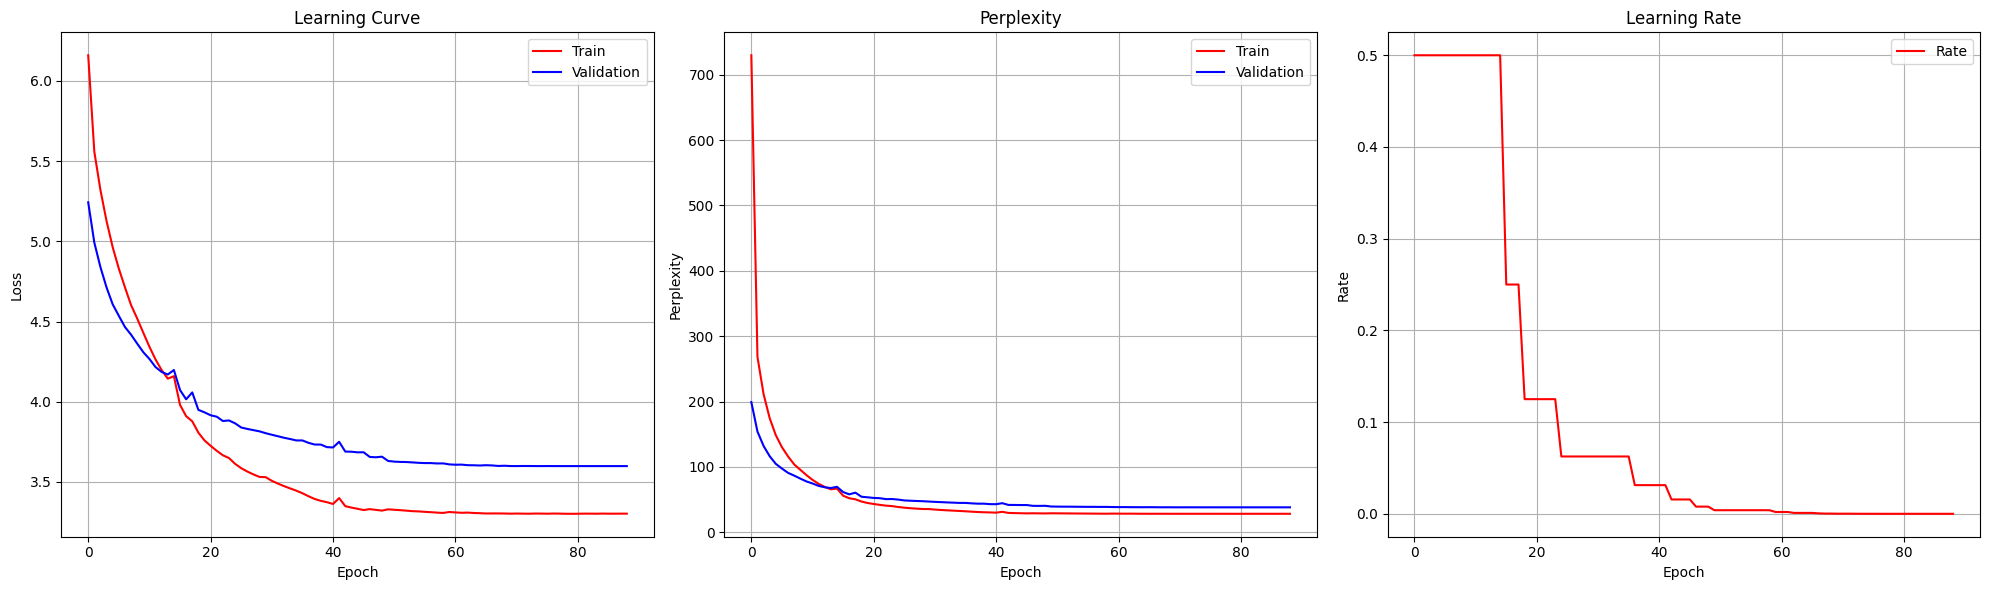

In [19]:
# Save as CSV
import pandas as pd
datas = {
    'epoch': range(epoch_counter),
    'loss_train': loss_train_hist,
    'loss_validation': loss_valid_hist,
    'perplexity_train': per_train_hist , 
    'perplexity_validation':per_valid_hist,
    'learning_rate': lr_train_hist
}
df = pd.DataFrame(datas)
df.to_csv("learningCurve.csv" , index=False)

fig, (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(20, 6))

ax1.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
ax1.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')
ax1.set_title('Learning Curve')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)
ax1.legend()

ax2.plot(range(epoch_counter), per_train_hist, 'r-', label='Train')
ax2.plot(range(epoch_counter), per_valid_hist, 'b-', label='Validation')
ax2.set_title('Perplexity')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Perplexity')
ax2.grid(True)
ax2.legend()

ax3.plot(range(epoch_counter), lr_train_hist, 'r-', label='Rate')
ax3.set_title('Learning Rate')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Rate')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

## Test Perplexity

In [20]:
#LanguageModel = H_LSTM

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()

loss_fn = nn.CrossEntropyLoss()
perp = Perplexity().to(device)

loss_valid , per_valid  = evaluate(model, valid_loader, loss_fn , perp )
print(f"Validation: Loss = {loss_valid:.4} , Perplexity = {per_valid:.4}")

loss_test , per_test  = evaluate(model, test_loader, loss_fn , perp)
print(f"Test: Loss = {loss_test:.4} , Perplexity = {per_test:.4}")

Validation: Loss = 3.599 , Perplexity = 38.15
Test: Loss = 3.489 , Perplexity = 35.18


# Text Generation

In [21]:
loss_fn = nn.CrossEntropyLoss()

model_path = 'model.pt'
model = torch.load(model_path)
model = model.to(device)
model.eval()
model

H_LSTM(
  (embedding): Embedding(33264, 500)
  (dropout_em): Dropout(p=0.1, inplace=False)
  (rnn1): LSTM(500, 500, batch_first=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (rnn2): LSTM(500, 500, batch_first=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (rnn3): LSTM(500, 500, batch_first=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=500, out_features=33264, bias=True)
)

In [22]:
num_trainable_params(model)

39.309264

In [23]:
def generate(prompt, max_seq_len, temperature, model ):

    global device
    global vocab_itos
    global seq_len
    global char2ind
    
    prompt_tokens = prompt.split(' ')
    prompt_tokens = [vocab[token] for token in prompt_tokens]  

    with torch.no_grad():
        current_token = torch.tensor(prompt_tokens).unsqueeze(0) 
        current_token = current_token.to(device)
        generated_text = prompt  
        for i in range(max_seq_len):
            output = model(current_token)
            probabilities = nn.functional.softmax(output[:, -1, :] / temperature, dim=-1)
            next_word = "<unk>"
            while next_word == "<unk>":
                next_token_id = torch.multinomial(probabilities, 1).item()
                next_word = vocab_itos[next_token_id]
            
            generated_text += " " + next_word

            next_token_id = torch.tensor([[next_token_id]]).to(device)
            if current_token.shape[1] < seq_len:
                current_token = torch.cat( ( current_token  , next_token_id ), dim=1)
            else:
                current_token = torch.cat( ( current_token[:, 1:]  , next_token_id ), dim=1)
            if next_word in ["<eos>", "."]:
                break
            del next_token_id
    return generated_text

prompt = "i think the movie"
generated_text = generate(prompt, 
                          max_seq_len = 100, 
                          temperature = 0.5, 
                          model = model)

print(generated_text)

i think the movie , and a few &lt; unk &gt; – four weeks after Bungie &apos; s death , &lt; unk &gt; by creating money for craft safety , especially together by completing a new comedy film director , whose work received positive reviews .
